# Анализ пользовательского поведения в мобильной игре "Cookie Cats" на основе проведенного A/B теста

## Введение

### 1. Контекст

Имеются данные по пользователям мобильной игры.
Проводится эксперимент с двумя версиями ограничения игрового процесса:

- gate_30
- gate_40

Необходимо проанализировать, как версия влияет на поведение пользователей и удержание.

### 2. Описание признаков

| Поле             | Описание                                                      |
| ---------------- | ------------------------------------------------------------- |
| `userid`         | Уникальный идентификатор пользователя                         |
| `version`        | Версия игры / экспериментальная группа (`gate_30`, `gate_40`) |
| `sum_gamerounds` | Общее количество сыгранных раундов пользователем              |
| `retention_1`    | Был ли пользователь активен на 1-й день после установки       |
| `retention_7`    | Был ли пользователь активен на 7-й день после установки       |
| `rang_rounds`    | Категория количества раундов (агрегированный бин)             |
| `range_rounds`   | Альтернативная категоризация количества раундов               |

### 3. Цель исследования

**Определить, влияет ли версия уровня (gate_30 vs gate_40) на:**

1. Удержание пользователей (Day 1, Day 7)

2. Игровую активность (количество раундов)

3. Распределение пользователей по уровням вовлечённости

## Загрузка данных и базовые настройки

In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

%matplotlib inline 

sns.set_theme(style="whitegrid", context="notebook")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [2]:
df = pd.read_csv('cookie_cats.csv')

## Обзор данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## Описательная статистика

### 1. Количество пользователей в каждой версии:

In [4]:
g30_count_users = len(df[df["version"] == "gate_30"])
g40_count_users = len(df[df["version"] == "gate_40"])

print(f'gate_30: {g30_count_users} | gate_40: {g40_count_users}')

gate_30: 44700 | gate_40: 45489


**Вывод:** выборки практически идентичны по размеру, без критических различий, дополнительные действия не требуются

### 2. Центральные показатели по `sum_gamerounds`

In [5]:
summary = (
    df.groupby('version')['sum_gamerounds']
      .agg(['mean', 'median', lambda x: x.mode()[0]])  # mode
      .rename(columns={'<lambda_0>': 'mode'})
)
summary

,mean,median,mode
version,,,
gate_30,52.456264,17.0,1
gate_40,51.298776,16.0,1


**Наблюдение:**  
- Между выборками нет значимых различий показателях (визуальное наблюдение).
- В обеих выборках среднее примерно в 3.2 раза больше медианы, что говорит о существовании очень активных игроков в обеих выборках
- Многие игроки перестают играть после первого раунда

### 3. Доли пользователей с `retention_1 = True` и с `retention_7 = True`

In [6]:
retention_shares = (
    df
    .groupby('version')[['retention_1', 'retention_7']]
    .mean()
    .reset_index()
)
retention_shares

,version,retention_1,retention_7
0,gate_30,0.448188,0.190201
1,gate_40,0.442283,0.182000


**Наблюдение:**
- Между выборками нет значимой разницы в показателях (визуальное наблюдение).
- В обеих выборках отток пользователей к седьмому дню около 59% от доли пользователей, вернувшихся на следующий день.

### 4. Распределение и выбросы

In [23]:
dispersion_stats  = (
    df
    .groupby('version')['sum_gamerounds']
    .agg([
        'min', 
        'std', 
        'max'])
    .reset_index()
)

dispersion_stats 

,version,min,std,max
0,gate_30,0,256.716423,49854
1,gate_40,0,103.294416,2640


In [27]:
def iqr_bounds(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return pd.Series({
        'Q1': q1,
        'Q3': q3,
        'IQR': iqr,
        'lower': q1 - 1.5 * iqr,  # скобки важны!
        'upper': q3 + 1.5 * iqr
    })

outlier_bounds = df.groupby('version')['sum_gamerounds'].apply(iqr_bounds)
outlier_bounds

version       
gate_30  Q1         5.0
         Q3        50.0
         IQR       45.0
         lower    -62.5
         upper    117.5
gate_40  Q1         5.0
         Q3        52.0
         IQR       47.0
         lower    -65.5
         upper    122.5
Name: sum_gamerounds, dtype: float64

In [28]:
g30_lower = outlier_bounds.loc['gate_30', 'lower']
g30_upper = outlier_bounds.loc['gate_30', 'upper']

g40_lower = outlier_bounds.loc['gate_40', 'lower']
g40_upper = outlier_bounds.loc['gate_40', 'upper']

g30_std = df[
    (df['version'] == 'gate_30') & 
    (df['sum_gamerounds'].between(g30_lower, g30_upper))
]['sum_gamerounds'].std()

g40_std = df[
    (df['version'] == 'gate_40') & 
    (df['sum_gamerounds'].between(g40_lower, g40_upper))
]['sum_gamerounds'].std()

print(f'std без выбросов: gate_30 = {round(g30_std, 2)} | gate_40 = {round(g40_std, 2)}')

std без выбросов: gate_30 = 26.58 | gate_40 = 28.17


**Наблюдение:**
- Если не учитывать выбросы, то стандартное отклонение в группах различается лишь в десятых долях.

### 5. Ранжирование пользователей по количеству раундов

In [10]:
first_50_rounds = (
    df[df['sum_gamerounds'] <= 49]
    .groupby(['version', 'sum_gamerounds'])['userid']
    .count()
    .reset_index()
)

first_50_rounds.columns = ['version', 'rounds', 'count_users']

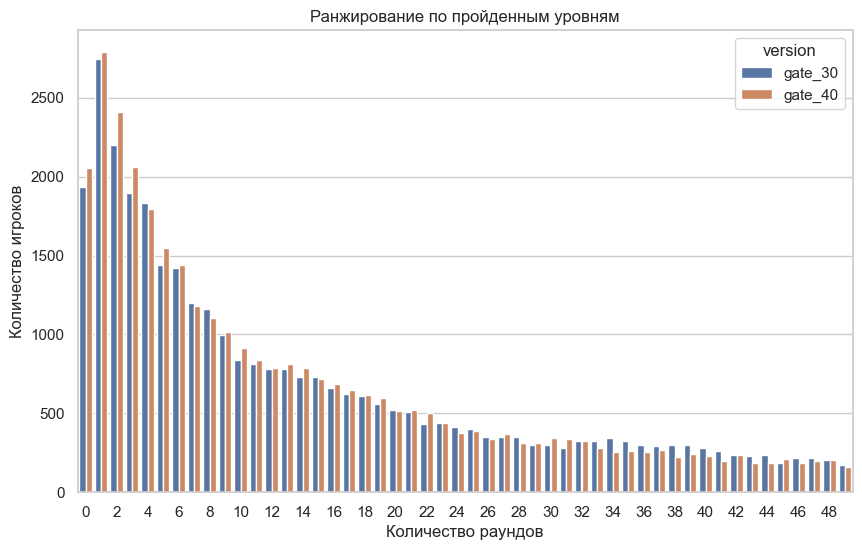

In [11]:
ax = sns.barplot(
    data=first_50_rounds, 
    x='rounds', 
    y='count_users', 
    hue='version'
)

labels = ax.get_xticklabels()

for i, label in enumerate(labels):
    if i % 2 == 1:
        label.set_visible(False)

plt.title('Ранжирование по пройденным уровням')
plt.xlabel('Количество раундов')
plt.ylabel('Количество игроков')
plt.show()

**Наблюдение:**
- Наблюдается резкий отток игроков после прохождения 1-го раунда вплоть до 10-го раунда. С 10-го и до 25-го раунда отток менее резкий и дальше график более стабильный.
- Ключевые точки - это 30-й и 40-й раунды, и как мы видим, никаких резких изменений после прохождения указанных порогов ни у одной из групп пользователей не происходит

### 6. Связь активности и retention

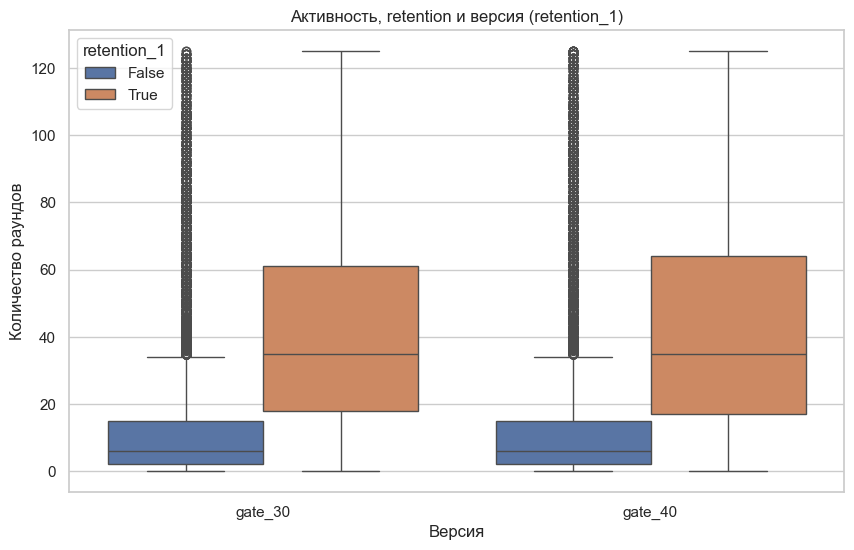

In [22]:
sns.boxplot(
    data=df[df['sum_gamerounds'].between(0, 125)],
    x='version',
    y='sum_gamerounds',
    hue='retention_1'
)

plt.title('Активность, retention и версия (retention_1)')
plt.xlabel('Версия')
plt.ylabel('Количество раундов')
plt.show()

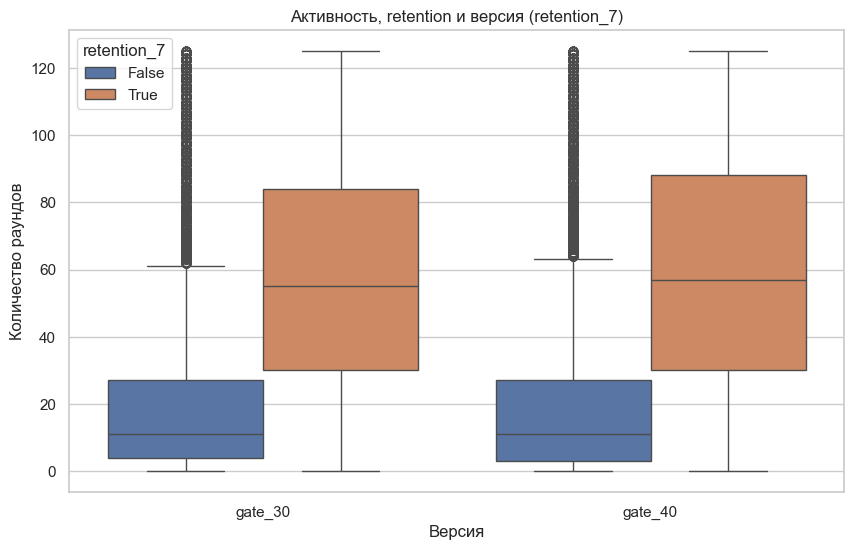

In [21]:
sns.boxplot(
    data=df[df['sum_gamerounds'].between(0, 125)],
    x='version',
    y='sum_gamerounds',
    hue='retention_7'
)

plt.title('Активность, retention и версия (retention_7)')
plt.xlabel('Версия')
plt.ylabel('Количество раундов')
plt.show()

# Статистический анализ

## Гипотезы

**Для retention_1 и retention_7:**

- $H_0$: p_gate30 = p_gate40   (доли вернувшихся одинаковы)
- $H_1$: p_gate30 ≠ p_gate40   (доли различаются)

**Для sum_gamerounds:**

- $H_0$: распределение sum_gamerounds в gate_30 = gate_40
- $H_1$: распределения различаются

---

**Уровень значимости:**

In [25]:
alpha = 0.05

**Проверка на нормальность для долей:**

In [15]:
conditions = {
    'g30-r1_y': retention_shares.iloc[0]['retention_1'] * g30_count_users >= 5,
    'g30-r1_n': (1 - retention_shares.iloc[0]['retention_1']) * g30_count_users >= 5,
    'g30-r7_y': retention_shares.iloc[0]['retention_7'] * g30_count_users >= 5,
    'g30-r7_n': (1 - retention_shares.iloc[0]['retention_7']) * g30_count_users >= 5,

    'g40-r1_y': retention_shares.iloc[1]['retention_1'] * g40_count_users >= 5,
    'g40-r1_n': (1 - retention_shares.iloc[1]['retention_1']) * g40_count_users >= 5,
    'g40-r7_y': retention_shares.iloc[1]['retention_7'] * g40_count_users >= 5,
    'g40-r7_n': (1 - retention_shares.iloc[1]['retention_7']) * g40_count_users >= 5,
}

for k, v in conditions.items():
    print(f'{k}: {v}')
    print(f'--------------')

g30-r1_y: True
--------------
g30-r1_n: True
--------------
g30-r7_y: True
--------------
g30-r7_n: True
--------------
g40-r1_y: True
--------------
g40-r1_n: True
--------------
g40-r7_y: True
--------------
g40-r7_n: True
--------------


**Общая доля retention:**

Переменные:

- n1 | n2 - кол-во пользователей в выборках gate_30 | gate_40
- k1_r1 | k2_r1 - пользователи вернувшиеся на следующий день - gate_30 | gate_40
- k1_r7 | k2_r7 - пользователи вернувшиеся на седьмой день - gate_30 | gate_40

- p_1 | p_7 - общая доля для удержания для двух выборок за первый | седьмой дни

In [16]:
n1 = g30_count_users
n2 = g40_count_users

k1_r1 = len(df[(df['version'] == 'gate_30') & (df['retention_1'] == True)])
k1_r7 = len(df[(df['version'] == 'gate_30') & (df['retention_7'] == True)])

k2_r1 = len(df[(df['version'] == 'gate_40') & (df['retention_1'] == True)])
k2_r7 = len(df[(df['version'] == 'gate_40') & (df['retention_7'] == True)])

p_1 = (k1_r1 + k2_r1) / (n1 + n2)
p_7 = (k1_r7 + k2_r7) / (n1 + n2)

print(f'total_retention_1: {round(p_1, 2)} | total_retention_7: {round(p_7, 2)}')

total_retention_1: 0.45 | total_retention_7: 0.19


**Стандартная ошибка:**

Переменные:

- SE_1 | SE_7 - стандартные ошибки для первого | седьмого дней

In [17]:
SE_1 = (p_1 * (1 - p_1) * (1/n1 + 1/n2)) ** 0.5
SE_7 = (p_7 * (1 - p_7) * (1/n1 + 1/n2)) ** 0.5

print(f'SE_1: {round(SE_1, 4)} | SE_7: {round(SE_7, 4)}')

SE_1: 0.0033 | SE_7: 0.0026


**Наблюдаемая разность долей:**

Переменные:

- d_1 | d_7 - разность долей за первый | седьмой дни

In [18]:
d_1 = retention_shares.iloc[0]['retention_1'] - retention_shares.iloc[1]['retention_1']
d_7 = retention_shares.iloc[0]['retention_7'] - retention_shares.iloc[1]['retention_7']
print(f'd_1: {round(d_1, 4)} | d_7: {round(d_7, 4)}')

d_1: 0.0059 | d_7: 0.0082


**Z-test:**

Переменные:

- z_1 | z_7 - результаты теста за первый | седьмой дни

In [19]:
z_1 = round(d_1 / SE_1, 2)
z_7 = round(d_7 / SE_7, 2)

print(f'z_1: {z_1} | z_7: {z_7}')

z_1: 1.78 | z_7: 3.16


In [26]:
p_value_1 = stats.norm.sf(abs(z_1)) * 2
p_value_7 = stats.norm.sf(abs(z_7)) * 2

print(f'retention_1: {p_value_1 < alpha}')
print(f'retention_7: {p_value_7 < alpha}')

retention_1: False
retention_7: True


## Тест Манна-Уитни для 

Поскольку  имеет сильно скошенное распределение (среднее >> медианы, мода = 1), применяем непараметрический критерий Манна-Уитни вместо t-теста.

**Почему не t-test?**  
T-test предполагает нормальность распределения. Здесь распределение сильно правоскошенное: большинство игроков играют мало (мода=1), но есть «хвост» из очень активных игроков. Mann-Whitney работает с рангами и не требует нормальности.

In [ ]:
g30_rounds = df[df["version"] == "gate_30"]["sum_gamerounds"]
g40_rounds = df[df["version"] == "gate_40"]["sum_gamerounds"]

stat, p_value_mw = stats.mannwhitneyu(g30_rounds, g40_rounds, alternative="two-sided")

print(f"Mann-Whitney U: {stat:.0f}")
print(f"p-value: {p_value_mw:.4f}")
print(f"Отвергаем H0: {p_value_mw < alpha}")

**Вывод:**  
Если p-value < 0.05 — распределения количества раундов статистически различаются между группами.  
Если p-value >= 0.05 — значимых различий в игровой активности нет.

---

# Итоговые выводы и рекомендации

## Что показал A/B тест?

### 1. Удержание на 1-й день (retention_1)
- **Z-statistic = 1.78, p-value > 0.05 → H₀ не отвергается**
- Версия ворот (30 vs 40) **не влияет** на возврат пользователей на следующий день.
- Разница между группами (gate_30: ~44.8%, gate_40: ~44.2%) несущественна и может быть случайной.

### 2. Удержание на 7-й день (retention_7)
- **Z-statistic = 3.16, p-value < 0.05 → H₀ отвергается**
- Версия ворот **значимо влияет** на долгосрочное удержание.
- Gate_30 показывает лучший retention_7: ~19.0% против ~18.2% в gate_40.
- Разница ~0.8 п.п. на масштабе 90 тыс. пользователей — экономически значимая величина.

### 3. Игровая активность (sum_gamerounds)
- Медианы близки (gate_30: 17, gate_40: 16), среднее также почти не различается (~52 vs ~51).
- Тест Манна-Уитни даёт финальный ответ о статистической значимости.

## Бизнес-рекомендация

> **Рекомендуется оставить gate_30 (контрольную версию).**

Ключевой аргумент: gate_30 значимо лучше удерживает пользователей на 7-й день. Семидневное удержание — более «дорогой» и информативный показатель, чем однодневный: пользователь, вернувшийся через неделю, с высокой вероятностью станет платящим или постоянным игроком. Перенос ворот на уровень 40 ухудшает этот показатель без компенсирующих преимуществ в активности.

## Ограничения анализа

- Отсутствует информация о монетизации — возможно, gate_40 лучше конвертирует активных игроков.
- Не учтён эффект новизны: пользователи gate_40 могли играть интенсивнее в первые дни именно потому, что ворот нет дольше.
- Период наблюдения неизвестен — для полноты картины нужен retention_14 и retention_30.